In [94]:
options(warn = -1)
options(messages = -1)

library(haven)
library(tidyverse)
library(OasisR)
library(sf)
library(ggspatial)
library(ggplot2)

#options(warn = 0)
#options(messages = 0)

In [4]:
df = read_dta('tomp_poverty.dta')
head(df)

bgroup10,urban,fams,fpov,fnopov,fpovkids,fnopovkids
361090001001,1,136,0,136,0,45
361090002001,1,15,0,15,0,0
361090002002,1,19,0,19,0,0
361090002003,1,18,0,18,0,5
361090003001,1,33,2,31,0,0
361090004001,1,103,10,93,5,60


### 1.A)

In [5]:
df %>% 
    group_by(urban) %>%
    summarize('rate_fams' = sum(fpovkids)/sum(fams))

urban,rate_fams
0,0.07894927
1,0.06230234


In Tompkins County, poverty rates among children with families seem higher in urban areas. Given that almost all of the county population is located in the urban centre of Ithaca (I think), the absolute numbers probably show that the majority of all poverty occurs in urban areas. Let's check:

In [6]:
df %>% 
    group_by(urban) %>%
    summarize('rate_fams' = sum(fpovkids))

urban,rate_fams
0,1094
1,394


If this is coded like I think it is, then the results sure tell a different story. Looks like TC is mostly a rural area, and the urban-rural divide may have little to do with poverty, at least among those with families. Let's quickly combine and check all families:

In [7]:
df %>%
    group_by(urban) %>%
    summarize('rate_all'= sum(fpov)/sum(fams))

urban,rate_all
0,0.09222775
1,0.09203036


Almost no difference when we look across families with and without children

### 1.b)

In [8]:
m <- df %>% select(fpovkids, fnopovkids)
Eta2 <- Eta2(m)
Eta2[1]

Warning message in segdataclean(x):
"following lines were deleted because of null population: 2, 3, 5, 26, 28"

[1] 0.1953

This number value of eta-squared seems relatively low, although I'm no expert in this area. The poor and non-poor live together in harmony.

### 1.c)

**Modifiable Arial Unit Problem (MAUP)**

This problem arises from the arbitrary nature of spatial unit definition. In this case, we may have found different levels of segregation in Tompkins County had we divided our subregions differently. Two neighboring regions separated by a vertical border may look non-segregated, but if they were instead divided horizontally, they might suddenly look highly segregated. 

**Spatial Auto-correlation**

This problem refers to covariation among the characteristics of proximal locations. Autocorrelation typically indicates some kind of clustering occurring on characteristics. In this case, we have shown roughly that poverty rates for families with and without children do not seem to cluster along urban-rural divides, but clusters may occur in some other way. 

### 2.a)

In [84]:
sf <- read_sf('tomp_bgroups/tomp_bgroups.shp')
sf <- st_transform(sf, 4269)
sf <- merge(sf, df, by = 'bgroup10')

head(sf %>% select(bgroup10, fpovkids, geometry))

bgroup10,fpovkids,geometry
361090001001,0,POLYGON ((-76.49218 42.4406...
361090002001,0,POLYGON ((-76.48364 42.4415...
361090002002,0,POLYGON ((-76.48364 42.4415...
361090002003,0,POLYGON ((-76.48861 42.4407...
361090003001,0,POLYGON ((-76.44981 42.4558...
361090004001,5,POLYGON ((-76.43846 42.4569...


[1] 152


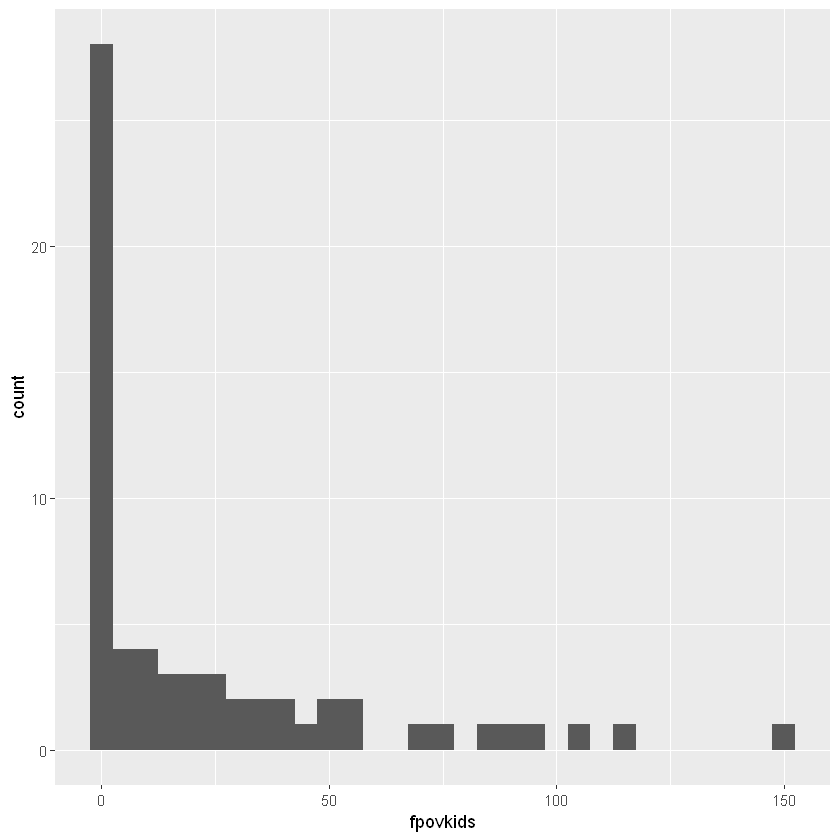

In [68]:
ggplot(sf, aes(x = fpovkids)) + geom_histogram(binwidth = 5)

In [85]:
# creating factor levels for fpovkids
sf <- sf %>% mutate(pov_groups = case_when(
    fpovkids > 99 ~ '100-152',
    fpovkids > 49 ~ '50-99',
    fpovkids > 0 ~ '1-49',
    fpovkids == 0 ~ '0'
))
sf$pov_groups <- as.factor(sf$pov_groups)
levels(sf$pov_groups) <- c('0', '1-49', '50-99', '100-152')

In [86]:
sites <- read_csv('tomp_sites.csv')
sf_sites <- st_as_sf(sites, coords = c('xlon', 'ylat'),
                    stringsAsFactors = FALSE,
                    crs = 4269)
head(sf_sites)

Parsed with column specification:
cols(
  idsite = col_double(),
  site = col_character(),
  street = col_character(),
  city = col_character(),
  st = col_character(),
  zip = col_double(),
  ylat = col_double(),
  xlon = col_double()
)


idsite,site,street,city,st,zip,geometry
1,CAROLINE,2439 SLATERVILLE RD,SLATERVILLE SPRINGS,NY,14881,POINT (-76.3719 42.3933)
2,CASSAVANT,32 SCHOOL ST,MCLEAN,NY,13102,POINT (-76.2939 42.5503)
3,DRYDEN,16 UNION ST,DRYDEN,NY,13053,POINT (-76.2957 42.4891)
4,ENFIELD,20 ENFIELD MAIN RD,ITHACA,NY,14850,POINT (-76.6318 42.4492)
5,FREEVILLE,43 MAIN ST,FREEVILLE,NY,13068,POINT (-76.3504 42.5111)
6,GROTON,516 ELM ST,GROTON,NY,13073,POINT (-76.3585 42.5854)


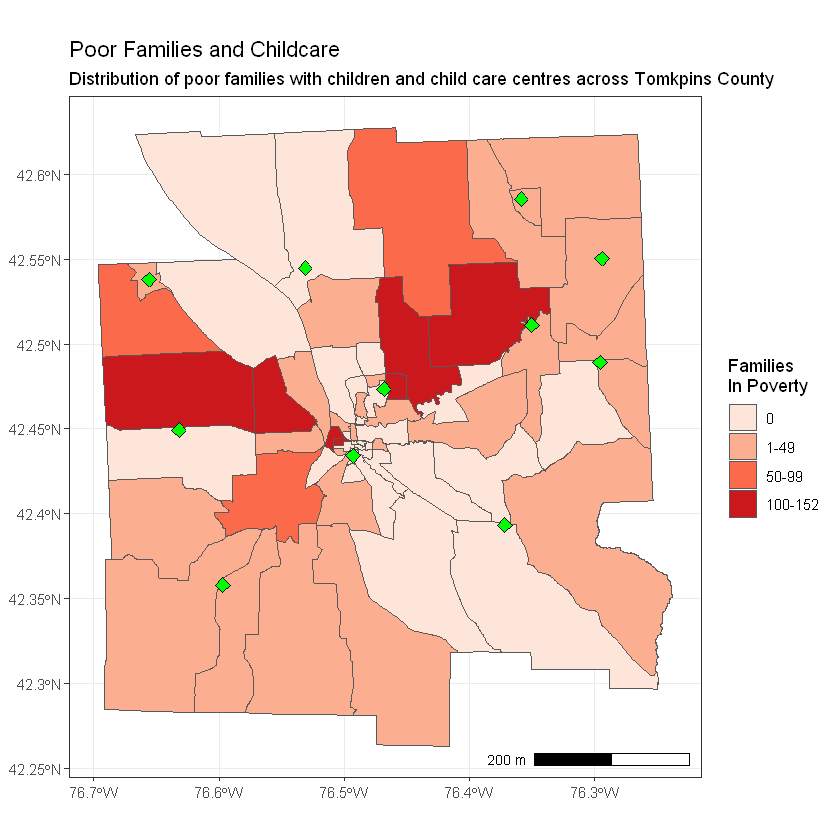

In [103]:
ggplot() +
    theme_bw() +
    geom_sf(data = sf, aes(fill = pov_groups)) +
    scale_fill_brewer(type = 'seq', palette = 'Reds', 'Families\nIn Poverty') +
    geom_sf(data = sf_sites, color = 'black', fill = 'green', shape = 23, size = 3) +
    annotation_scale(location = 'br', plot_unit = 'mi') +
    labs(title = 'Poor Families and Childcare',
        subtitle = 'Distribution of poor families with children and child care centres across Tomkpins County')

### 2.b)

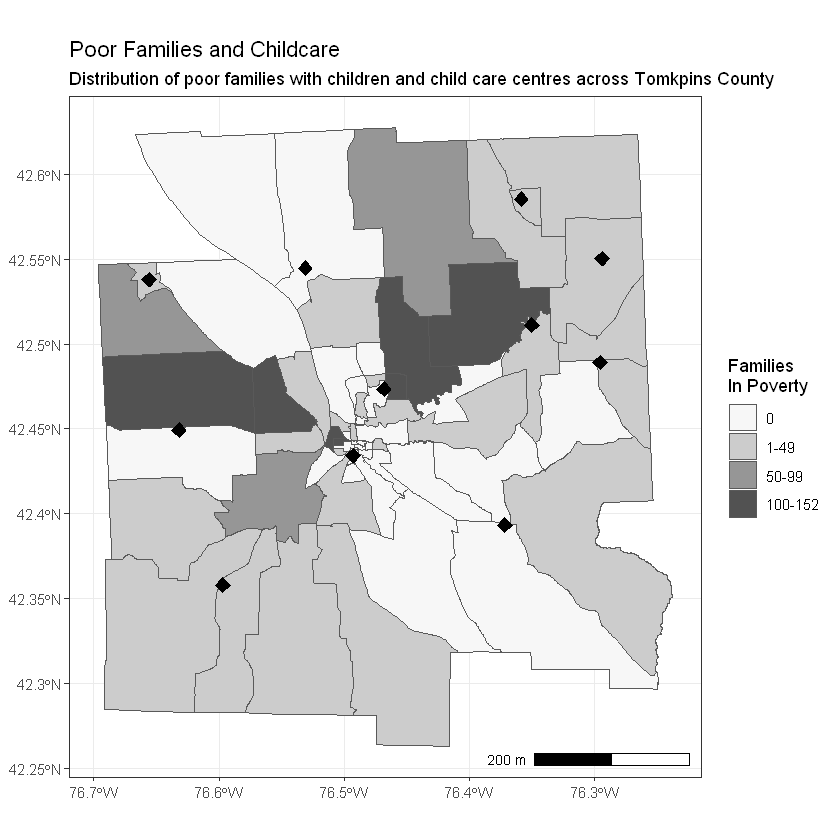

In [102]:
ggplot() +
    theme_bw() +
    geom_sf(data = sf, aes(fill = pov_groups)) +
    scale_fill_brewer(type = 'seq', palette = 'Greys', 'Families\nIn Poverty') +
    geom_sf(data = sf_sites, color = 'black', fill = 'black', shape = 23, size = 3) +
    annotation_scale(location = 'br', plot_unit = 'mi') +
    labs(title = 'Poor Families and Childcare',
        subtitle = 'Distribution of poor families with children and child care centres across Tomkpins County')

I don't think I gave up any information here. Perhaps this is a little less readable.